# GitHub analysis client
This notebook assumes that Pulsar is running and there are already partial results available

In [1]:
import matplotlib.pyplot as plt
import operator
import os
import pandas as pd
import sortedcontainers
from pulsar_wrapper import PulsarConnection

In [2]:
class LanguageTuple(object):
    """ Data Type to support tuple in-place sorting using sortedcontainers """
    def __init__(self, lang_tuple):
        self.lang = lang_tuple[0]
        self.value = int(lang_tuple[1] or 0)
        
    def __repr__(self):
        return f"('{self.lang}', {self.value})"

def sort_results(language_stats, field, num_results=None):
    lang_repos = sortedcontainers.SortedKeyList(key=lambda x: -x.value)
    for language in language_stats:
        lang_repos.add(LanguageTuple((language, language_stats[language][field])))
    return list(lang_repos[:num_results])

In [3]:
# Function to plot the results
def plot_result(result_tuple, title='', xlabel='', ylabel=''):
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)

    ax.set_ylabel(ylabel)
    ax.set_title(title)

    x_axis = [val.lang for val in result_tuple]
    y_axis = [val.value for val in result_tuple]
    plt.bar(range(len(result_tuple)), y_axis, tick_label=x_axis)
    plt.show()

In [4]:
# Take Pulsar host value from the environment variables
environment = os.environ
pulsar_host = environment.get("pulsar_host")
# If not set, assume its running in localhost
if (pulsar_host is None): pulsar_host = 'localhost'
my_pulsar = PulsarConnection(ip_address=pulsar_host)

2022-06-03 20:31:23.083 INFO  [140640557295424] ClientConnection:189 | [<none> -> pulsar://localhost:6650] Create ClientConnection, timeout=10000
2022-06-03 20:31:23.083 INFO  [140640557295424] ConnectionPool:96 | Created connection for pulsar://localhost:6650
2022-06-03 20:31:23.091 INFO  [140639605208832] ClientConnection:375 | [127.0.0.1:57288 -> 127.0.0.1:6650] Connected to broker
2022-06-03 20:31:23.094 INFO  [140639605208832] HandlerBase:64 | [persistent://public/static/initialized, reader-491ffea6b7, 0] Getting connection from pool
2022-06-03 20:31:23.096 INFO  [140639605208832] ConsumerImpl:224 | [persistent://public/static/initialized, reader-491ffea6b7, 0] Created consumer on broker [127.0.0.1:57288 -> 127.0.0.1:6650] 
Found 'Initializing' message
Found 'Initialized' message
2022-06-03 20:31:23.108 INFO  [140640557295424] ConsumerImpl:999 | [persistent://public/static/initialized, reader-491ffea6b7, 0] Closing consumer for topic persistent://public/static/initialized
2022-06-

In [5]:
cur_cutoff_date = my_pulsar.get_current_cuttoff_date()

2022-06-03 20:31:26.696 INFO  [140639605208832] HandlerBase:64 | [persistent://public/static/initialized, reader-1bf6486d68, 1] Getting connection from pool
2022-06-03 20:31:26.697 INFO  [140639605208832] ConsumerImpl:224 | [persistent://public/static/initialized, reader-1bf6486d68, 1] Created consumer on broker [127.0.0.1:57288 -> 127.0.0.1:6650] 
2022-06-03 20:31:26.701 INFO  [140640557295424] ConsumerImpl:999 | [persistent://public/static/initialized, reader-1bf6486d68, 1] Closing consumer for topic persistent://public/static/initialized
2022-06-03 20:31:26.702 INFO  [140639605208832] ConsumerImpl:1055 | [persistent://public/static/initialized, reader-1bf6486d68, 1] Closed consumer 1


In [6]:
cur_cutoff_date

'2021-01-02'

In [7]:
my_pulsar.process_results(cutoff_date='2021-01-03')

2022-06-03 20:31:33.291 INFO  [140639605208832] HandlerBase:64 | [persistent://public/static/initialized, reader-f45aeb87da, 2] Getting connection from pool
2022-06-03 20:31:33.293 INFO  [140639605208832] ConsumerImpl:224 | [persistent://public/static/initialized, reader-f45aeb87da, 2] Created consumer on broker [127.0.0.1:57288 -> 127.0.0.1:6650] 
2022-06-03 20:31:33.296 INFO  [140640557295424] ConsumerImpl:999 | [persistent://public/static/initialized, reader-f45aeb87da, 2] Closing consumer for topic persistent://public/static/initialized
2022-06-03 20:31:33.296 INFO  [140639605208832] ConsumerImpl:1055 | [persistent://public/static/initialized, reader-f45aeb87da, 2] Closed consumer 2
2022-06-03 20:31:33.299 INFO  [140639605208832] HandlerBase:64 | [persistent://public/static/languages, reader-77a390b04c, 3] Getting connection from pool
2022-06-03 20:31:33.300 INFO  [140639605208832] ConsumerImpl:224 | [persistent://public/static/languages, reader-77a390b04c, 3] Created consumer on b

True

In [8]:
language_stats = my_pulsar.get_languages_stats()

2022-06-03 20:31:42.794 INFO  [140639605208832] HandlerBase:64 | [persistent://public/static/language_results, reader-dd1ac11992, 5] Getting connection from pool
2022-06-03 20:31:42.796 INFO  [140639605208832] ConsumerImpl:224 | [persistent://public/static/language_results, reader-dd1ac11992, 5] Created consumer on broker [127.0.0.1:57288 -> 127.0.0.1:6650] 
2022-06-03 20:31:42.827 INFO  [140640557295424] ConsumerImpl:999 | [persistent://public/static/language_results, reader-dd1ac11992, 5] Closing consumer for topic persistent://public/static/language_results
2022-06-03 20:31:42.829 INFO  [140640557295424] ConsumerImpl:1055 | [persistent://public/static/language_results, reader-dd1ac11992, 5] Closed consumer 5


In [9]:
repo_sum, num_tests, num_ci = 0, 0, 0
for language in language_stats:
    repo_sum+=int(language_stats[language]['num_repos'] or 0)
    num_tests+=int(language_stats[language]['num_tests'] or 0)
    num_ci+=int(language_stats[language]['num_ci'] or 0)
print(f"Num repos: {repo_sum}")
print(f"Num tests: {num_tests}")
print(f"Num ci: {num_ci}")

Num repos: 3975
Num tests: 714
Num ci: 46


# 1. Top programming languages based on the number of projects developed

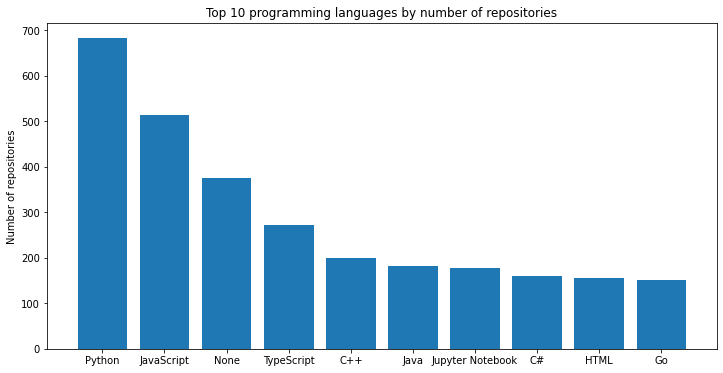

In [10]:
# Define the number of top languages to return, get the results, and plot them
num_results = 10
lang_repos = sort_results(language_stats, 'num_repos', num_results)
plot_result(lang_repos, 
          title=f'Top {len(lang_repos)} programming languages by number of repositories', 
          xlabel='', ylabel='Number of repositories')

# 2. Repositories with most commits

In [13]:
top_repos = my_pulsar.get_top_commits(20)

2022-06-03 20:32:33.379 INFO  [140639605208832] HandlerBase:64 | [persistent://public/static/initialized, reader-73a7b2c65e, 8] Getting connection from pool
2022-06-03 20:32:33.382 INFO  [140639605208832] ConsumerImpl:224 | [persistent://public/static/initialized, reader-73a7b2c65e, 8] Created consumer on broker [127.0.0.1:57288 -> 127.0.0.1:6650] 
2022-06-03 20:32:33.386 INFO  [140640557295424] ConsumerImpl:999 | [persistent://public/static/initialized, reader-73a7b2c65e, 8] Closing consumer for topic persistent://public/static/initialized
2022-06-03 20:32:33.386 INFO  [140639605208832] ConsumerImpl:1055 | [persistent://public/static/initialized, reader-73a7b2c65e, 8] Closed consumer 8

*** Showing partial results up to 2021-01-03 (info is still being processed) ***

2022-06-03 20:32:33.387 INFO  [140639605208832] HandlerBase:64 | [persistent://public/static/2021-01-03_result_commit, reader-bf1ebc5357, 9] Getting connection from pool
2022-06-03 20:32:33.388 INFO  [140639605208832] Con

In [14]:
pd.DataFrame(top_repos, columns=['Repository name','Number of commits'])

,Repository name,Number of commits
0,AOSP-Krypton/frameworks_base,661920
1,llvm-mos/llvm-mos,421998
2,Status-Plus/StatusPlus,396098
3,GiorgioComitini/COVID-19,107359
4,merchantsedition/merchantsedition,37380
5,WangTingMan/chromebase,21989
6,helaili/enterprise-showcase,12148
7,wiredfool/pillow-fuzz,11254
8,scriptex/uptime,10998
9,Ch4t4r/Nebulo,3465


# 3. Top languages with testdriven approach

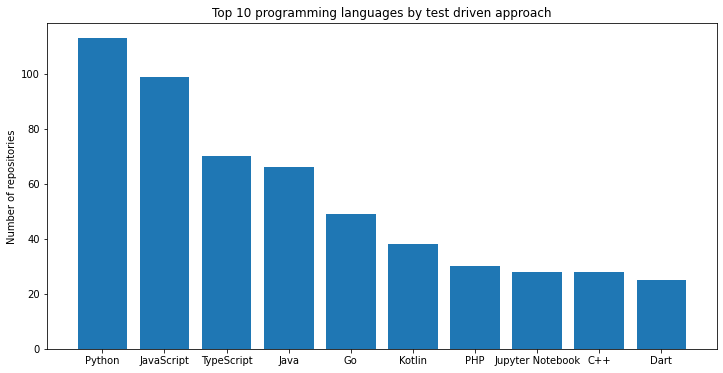

In [15]:
# Define the number of top languages to return, get the results, and plot them
num_results_test = 10
lang_repos_test = sort_results(language_stats, 'num_tests', num_results_test)
plot_result(lang_repos_test, 
          title=f'Top {len(lang_repos_test)} programming languages by test driven approach', 
          xlabel='', ylabel='Number of repositories')

# 4. Top languages with testdriven approach and continous integration

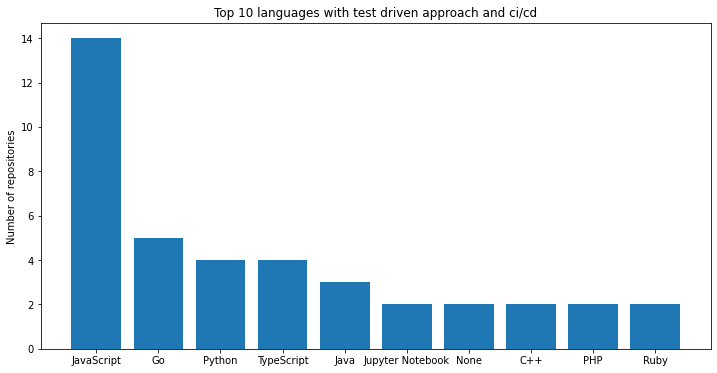

In [16]:
# Define the number of top languages to return, get the results, and plot them
num_results_ci = 10
lang_repos_ci = sort_results(language_stats, 'num_ci', num_results_ci)
plot_result(lang_repos_ci, 
          title=f'Top {len(lang_repos_ci)} languages with test driven approach and ci/cd', 
          xlabel='', ylabel='Number of repositories')

In [17]:
my_pulsar.close()

2022-06-03 20:32:55.420 INFO  [140640557295424] ClientImpl:496 | Closing Pulsar client with 3 producers and 10 consumers
2022-06-03 20:32:55.422 INFO  [140640557295424] ClientConnection:1559 | [127.0.0.1:57288 -> 127.0.0.1:6650] Connection closed
2022-06-03 20:32:55.422 INFO  [140640557295424] ClientConnection:263 | [127.0.0.1:57288 -> 127.0.0.1:6650] Destroyed connection
